# CIS 545 Final Project: Stock Prediction Using Machine Learning
# By Thanyaphorn Thangthanakul

The markets are always changing, and people spend so much time trying to
predict them. Quantitative finance, a field that I am very interested in, is new and fast-growing. While many people must have done
predictions on the stock data before, I know that each analysis yields different
results and implications. It depends a lot on which data and which perspective we
want to explore, and I hope to use this project as a starting point for my interests
in quant finance and further research. I hope to make this project extensible to anyone interested in making improvements on
the model etc. and hope to make this project my starting point/inspiration of creating
profitable trading algorithms.

There are two major school of thoughts when analyzing stock markets. Technical analysis pays close attention to stock price, patterns, charts, and trends to analyze how the stocks will perform in the future. Meanwhile, fundamental analysis seeks to measure the intrinsic value of the stocks. Everything from economic condition to financial condition and management of companies, its earnings, expenses, assets, and liabilities are all important characteristics to fundamental analysts.

In this project, I decided to split my analysis into 2 parts with different objectives:


1.   Technical Analysis: use closing price of 60 previous days of each stock to predict the stock price at that date.
2.   Fundamental Analysis: predict S&P500 stock outperformance based on their fundamental information and determine which factors contribute to the outperformance of the stocks. 

In [3]:
!pip install pandas-datareader
!pip install keras
!pip install FundamentalAnalysis

In [0]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import FundamentalAnalysis as fa
import bs4 as bs
import pickle
import random
import requests
from google.colab import files
from statsmodels.graphics.tsaplots import plot_acf

# Part 1: Technical Analysis

## Data Exploration and Setup

I decided to use daily stock price data for the 5 years, from January 2015 to January 2020. I picked the start date in the middle of the month to avoid starting with holidays and also chose to stop at January to exclude the current market fluctuation due to the pandemic. I picked Apple stock to perform data exploration and demonstrate the model fitting and prediction.

In [0]:
start_date = '2015-01-10'
end_date = '2020-01-10'

In [6]:
aapl_stock = pdr.DataReader('AAPL', data_source='yahoo', start = start_date, end = end_date)
aapl_stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-12,112.629997,108.800003,112.599998,109.250000,49650800.0,100.143120
2015-01-13,112.800003,108.910004,111.430000,110.220001,67091900.0,101.032280
2015-01-14,110.489998,108.500000,109.040001,109.800003,48956600.0,100.647285
2015-01-15,110.059998,106.660004,110.000000,106.820000,60014000.0,97.915672
2015-01-16,107.580002,105.199997,107.029999,105.989998,78513300.0,97.154854


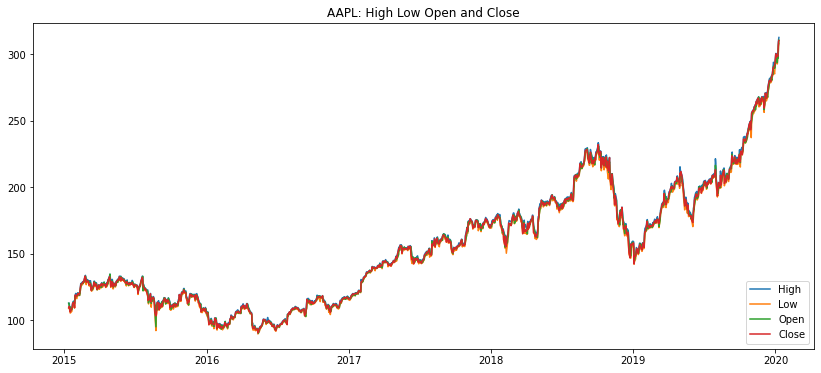

In [7]:
plt.figure(figsize=(14, 6))
plt.title("AAPL: High Low Open and Close")
plt.plot(aapl_stock[['High', 'Low', 'Open', 'Close']])
plt.legend(['High', 'Low', 'Open', 'Close'], loc='lower right')
plt.show()

From the plot above, I saw that 'High', 'Low', 'Open', and 'Close' data essentially follow the same trend. Therefore, I chose to use just the 'Close' price for the analysis.

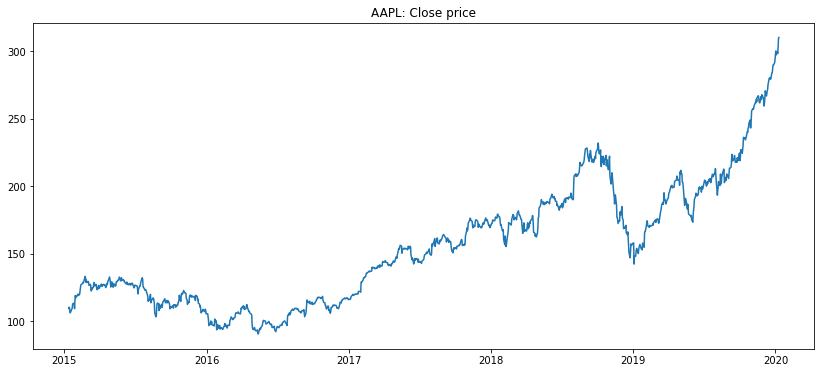

In [8]:
plt.figure(figsize=(14, 6))
plt.title("AAPL: Close price")
plt.plot(aapl_stock['Close'])
plt.show()

My assumption is that the previous days' closing price will be a strong predictor of the current closing price of each day. In this exploration step, I plotted the 30 and 60-day moving average too see the trends. We can see that the trends for both 30 and 60 days are both similar to the price.

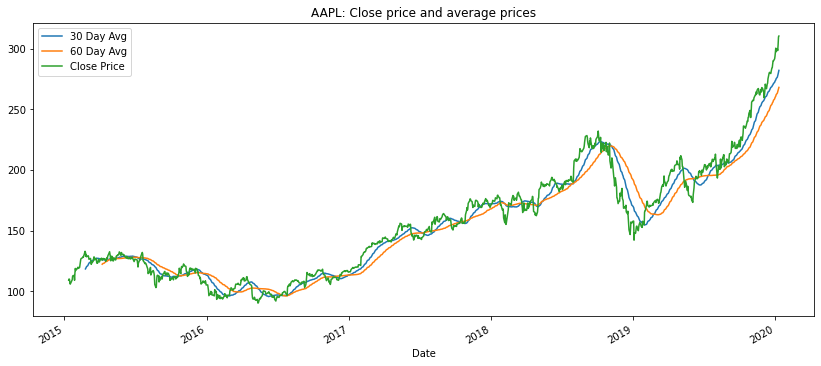

In [9]:
plt.figure(figsize=(14, 6))
plt.title("AAPL: Close price and average prices")
aapl_stock['Close'].rolling(window=30).mean().plot(label='30 Day Avg')
aapl_stock['Close'].rolling(window=60).mean().plot(label='60 Day Avg')
aapl_stock['Close'].plot(label='Close Price')
plt.legend()
plt.show()

One major problem is that by nature, stock prices are autocorrelated. This violates the assumption of the linear model, but I believe it is still insightful to fit the linear model.

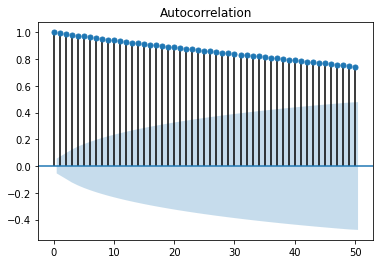

In [10]:
plot_acf(aapl_stock['Close'], lags = 50);

In [0]:
aapl_close = aapl_stock.filter(['Close'])
aapl_data = aapl_close.values

I chose to split the data by the date, with the assumption that a good model will be useful in predicting future values. Then, I created the train and test datasets by creating and populating the columns for each of the previous 60 closing days. For the dependent variable, I put the data of each of the closing day associated with those previous 60 days.

In [0]:
#Train the model on the first 80% of the data
training_data_len = math.ceil(len(aapl_data)*.8) 

#Create train dataset out of 60 previous trading days
train_data = aapl_data[0:training_data_len, : ]
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [0]:
#Create test dataset
test_data = aapl_data[training_data_len - 60: , : ]
x_test = []
y_test =  []
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    y_test.append(test_data[i,0])

In [0]:
#Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

## Linear Regression

First, I performed the simple linear regression fit for the training data. The R-squared is high for the fit, with 99%. The RMSE for test data is 3.45. Also, by the visualization below, we can see that our prediction performs pretty well.

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
# R squared????
print(lin_reg.score(x_train, y_train))
print(lin_reg.score(x_test, y_test))

0.9962419257374365
0.9909762138877197


In [17]:
# find RMSE value
from sklearn.metrics import mean_squared_error

y_predict = lin_reg.predict(x_test)
lin_reg_mse = mean_squared_error(y_predict, y_test)
rmse = math.sqrt(lin_reg_mse)
rmse

3.4470553493885867

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


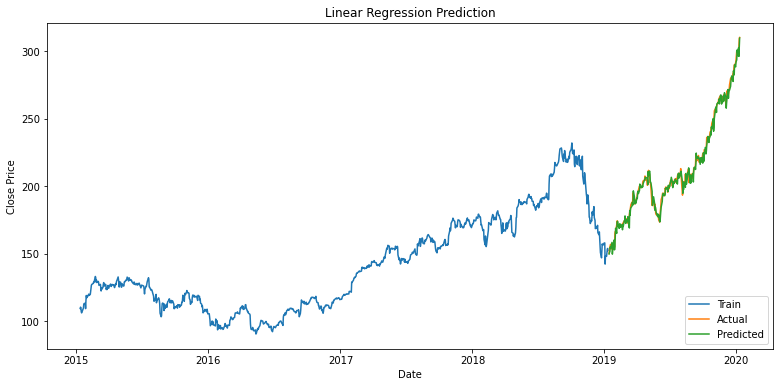

In [18]:
#Plot the graph of actual vs predicted values
train = aapl_close[:training_data_len]
valid = aapl_close[training_data_len:]
valid['Predictions'] = y_predict
plt.figure(figsize=(13,6))
plt.title('Linear Regression Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()

## Random Forest

Next, I decided to use the Random Forest Model, which is an ensemble learning method. I chose the number of estimators and the max depth to prevent the overfitting of the data. However, we can see that the score of the model is very high (99.91%) for the train data, but significantly lower for the test data (53.96%). This still indicates that there is a lot of overfitting, and thus the RMSE is high, at around 23.8. From the plot below, I could understand that the model is not trained to deal with data that is significantly outside of the range of the training set, so the model cannot further give a valuable result of the testing prediction after a certain value. 

In [19]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=12, n_estimators=10, max_depth = 10) 
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=12, verbose=0, warm_start=False)

In [20]:
print(rfr.score(x_train, y_train))
print(rfr.score(x_test, y_test))

0.9991191387778122
0.5395884250555992


In [21]:
y_predict = rfr.predict(x_test)
rfr_mse = mean_squared_error(y_predict, y_test)
rmse = math.sqrt(rfr_mse)
rmse

24.622206950045943

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


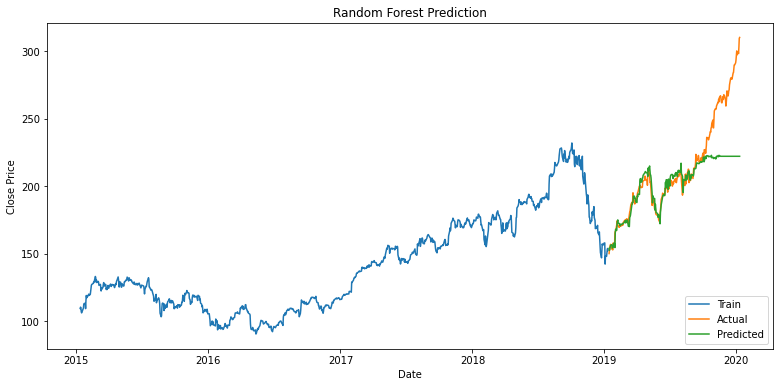

In [22]:
#Plot the graph of actual vs predicted values
train = aapl_close[:training_data_len]
valid = aapl_close[training_data_len:]
valid['Predictions'] = y_predict
plt.figure(figsize=(13,6))
plt.title('Random Forest Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()

##LSTM

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. I found that LSTM neural networks are well-suited to making predictions based on time series data, which in this case is the stock price. I decided to use 2 LSTM and 2 Dense layers in this analysis. The plot shows that the prediction closely follows the actual data, with a trend of the predicted being a bit slower. The result RMSE is higher than that of the linear model. However, as I am just a novice on the topic LSTM model, I believe that there is a big room for improvement and tuning for the model layers for future studies. 

In [0]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(aapl_data)

#Create train datasets
train_data = scaled_data[0:training_data_len  , : ]
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [0]:
#Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data for the LSTM model: 3D input
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [0]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
948/948 [==============================] - 38s 40ms/step - loss: 0.0017


In [0]:
#Create test datasets
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  aapl_data[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [0]:
#Convert to a numpy array 
x_test = np.array(x_test)
#Reshape the data for the LSTM model: 3D input
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [30]:
#Find predictions and RMSE
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

11.17272464687043

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


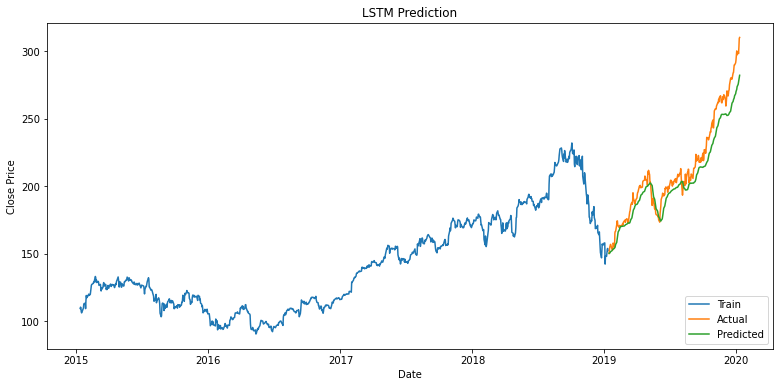

In [31]:
#Plot the graph of actual vs predicted values
train = aapl_close[:training_data_len]
valid = aapl_close[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(13,6))
plt.title('LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()

##Summary: analyzing multiple stocks

I created a function to scrape wikipedia data to get the tickers of all S&P500 companies using BeautifulSoup. Then, define function for Linear and Random Forest Regression and use those to create summary_df to compare the result of the two regressions. We can see that in general, linear regression performs better. The main reason might be that random forest is not equipped for analyzing data outside the training range.

In [0]:
def find_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        t = row.findAll('td')[0].text
        tickers.append(t.split('\n')[0])
        
    return tickers

In [0]:
sp_tickers = find_sp500_tickers()

In [0]:
# pick random 50 companies to use for comparison
random.seed(40)
r_tickers = random.sample(sp_tickers, 50)

In [0]:
start_date = '2015-01-10'
end_date = '2020-01-10'
training_data_len = math.ceil(len(aapl_data)*.8) 

In [0]:
def linearreg(x_train, y_train, x_test, y_test):
  lin_reg = LinearRegression()
  lin_reg.fit(x_train, y_train)
  score = lin_reg.score(x_test, y_test)
  y_predict = lin_reg.predict(x_test)
  lin_reg_mse = mean_squared_error(y_predict, y_test)
  rmse = math.sqrt(lin_reg_mse)
  return score, rmse

In [0]:
def rfreg(x_train, y_train, x_test, y_test):
  rfr = RandomForestRegressor(random_state=12, n_estimators=10, max_depth = 8) 
  rfr.fit(x_train, y_train)
  score = rfr.score(x_test, y_test)
  y_predict = rfr.predict(x_test)
  rmse = math.sqrt(mean_squared_error(y_predict, y_test))
  return score, rmse

In [0]:
def create_summary(tickers):
  rows_list = []
  for ticker in tickers:
    stock = pdr.DataReader(ticker, data_source='yahoo', start = start_date, end = end_date)
    stock_close = stock.filter(['Close'])
    stock_data = stock_close.values
    train_data = stock_data[0:training_data_len, : ]
    x_train=[]
    y_train = []
    for i in range(60,len(train_data)):
      x_train.append(train_data[i-60:i,0])
      y_train.append(train_data[i,0])

    test_data = stock_data[training_data_len - 60: , : ]
    x_test = []
    y_test =  []
    for i in range(60,len(test_data)):
      x_test.append(test_data[i-60:i,0])
      y_test.append(test_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    dict1 = {}
    lr_score, lr_rmse = linearreg(x_train, y_train, x_test, y_test)
    rf_score, rf_rmse = rfreg(x_train, y_train, x_test, y_test)
    dict1['stock'] = ticker
    dict1['LinearRegScore'] = lr_score
    dict1['LinearRegRMSE'] = lr_rmse
    dict1['RandomForestScore'] = rf_score
    dict1['RandomForestRMSE'] = rf_rmse
    rows_list.append(dict1)

  return rows_list

In [0]:
# remove the tickers that gave errors as there is not enough data
r_tickers.remove("OTIS")
r_tickers.remove('CARR')

In [0]:
# Takes a long time
summary = create_summary(r_tickers)

In [0]:
summary_df = pd.DataFrame(summary)

In [54]:
summary_df.head()

,stock,LinearRegScore,LinearRegRMSE,RandomForestScore,RandomForestRMSE
0,HFC,0.949189,1.014729,0.933848,1.157827
1,LKQ,0.980041,0.498055,0.962609,0.681692
2,TDG,0.978018,8.272288,-5.303245,140.079462
3,JNJ,0.909834,1.499712,0.900462,1.575727
4,ARE,0.975040,1.488978,-3.578099,20.165586


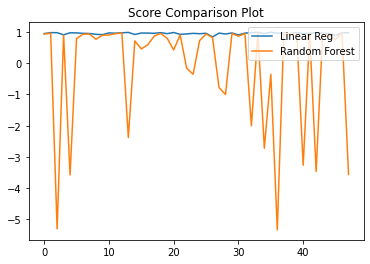

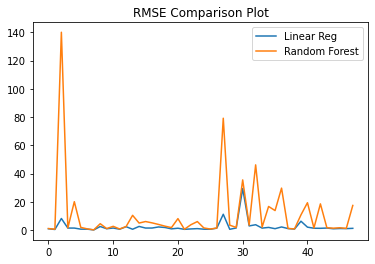

In [55]:
plt.plot(summary_df['LinearRegScore'])
plt.plot(summary_df['RandomForestScore'])
plt.title("Score Comparison Plot")
plt.legend(['Linear Reg', 'Random Forest'], loc='upper right')
plt.show()
plt.plot(summary_df['LinearRegRMSE'])
plt.plot(summary_df['RandomForestRMSE'])
plt.title("RMSE Comparison Plot")
plt.legend(['Linear Reg', 'Random Forest'], loc='upper right')
plt.show()

## Extra: Time Series with Prophet

Since there is a lot of autocorrelation in the close price data, I thought it would be interesting to see the time series prediction. I used Prophet for time series prediction. The result was very different from what I found above, and also this needs more tuning. Still, the trend is going up, similar to the actual data.

In [0]:
# Rerun this after transformation to get the original data
start_date = '2015-01-10'
end_date = '2020-01-10'
aapl_stock = pdr.DataReader('AAPL', data_source='yahoo', start = start_date, end = end_date)

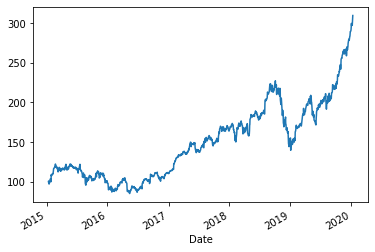

In [57]:
aapl_stock['Adj Close'].plot()

In [0]:
aapl_stock = aapl_stock.reset_index().rename(columns={'Date':'ds', 'Adj Close':'y'})

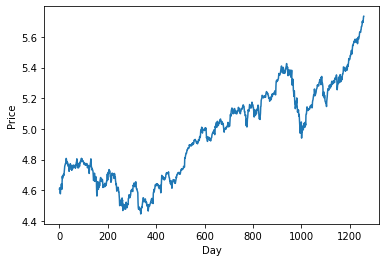

In [59]:
# Log Transform Data
aapl_stock['y'] = pd.DataFrame(np.log(aapl_stock['y']))

# plot data
plt.plot(aapl_stock['y'])
plt.ylabel('Price')
plt.xlabel('Day')
plt.show()

In [0]:
training_data_len = math.ceil(len(aapl_stock) *.90) 
df_train = aapl_stock[:training_data_len]
df_test = aapl_stock[training_data_len:]

In [61]:
from fbprophet import Prophet

pmodel = Prophet(interval_width=0.95, daily_seasonality=True)
pmodel.fit(df_train)
future = pmodel.make_future_dataframe(periods=125, freq='MS')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [0]:
forecast = pmodel.predict(future)

In [63]:
# retransform using e
y_hat = np.exp(forecast['yhat'][training_data_len:])
y_true = np.exp(aapl_stock['y'])
 
# compute the mean square error
rmse = math.sqrt(((y_hat - y_true) ** 2).mean())
rmse

55.821544603260705

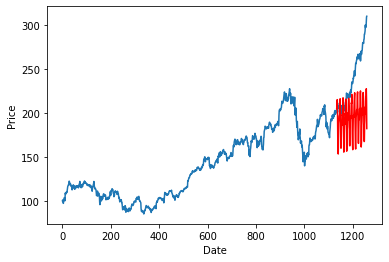

In [64]:
plt.plot(y_true, label='Original');
plt.plot(y_hat, color='r', label='Forecast');
plt.ylabel('Price');
plt.xlabel('Date');
plt.show()

#Part 2: Fundamental Analysis

**Warning**: the regression models do not give out useful results. The classification models give considerably accurate results when given high threshold value, but the 
true positive rate is very low (not much better than random). Although the findings might not be applicable for now, I chose to this part for the project because I believe this can lead to effective modifications or further research.

In this part of the project, I first get the quarterly fundamental data, such as PE ratio, Market cap, etc. of each stock in the S&P using the package 
[FundamentalAnalysis](https://pypi.org/project/FundamentalAnalysis/). Then, I merge this table with the table about the price change from this quarter to the next in comparison to the change in the S&P500 index. That is, I intended to use the fundamental data to predict the outperformance of each stock.

## Data Setup

In [0]:
sp_tickers = find_sp500_tickers()

In [0]:
# remove all the tickers that cause problem when calling get_fundamentals
tickers_all = sp_tickers
tickers_all.remove('CARR')
tickers_all.remove('J')
tickers_all.remove('OTIS')
tickers_all.remove('TFC')
tickers_all.remove('BRK.B')
tickers_all.remove('BF.B')

In [0]:
fundamentals = ['Market Cap', 'PE ratio', 
       'Enterprise Value over EBITDA', 'Earnings Yield', 
       'Debt to Equity', 'Net Debt to EBITDA',
       'Current ratio', 'Income Quality','Dividend Yield', 'Payout Ratio', 
       'SG&A to Revenue', 'R&D to Revenue', 'Capex to Revenue',
       'Stock-based compensation to Revenue', 'Working Capital',
       'Net Current Asset Value']

In [0]:
def get_fundamentals(tickers_all):
  for ticker in tickers_all:
    metrics_df = fa.key_metrics(ticker, period="quarter")
    metrics_dft = metrics_df.T
    metrics_fea = metrics_dft[fundamentals]
    funda_df = metrics_fea.reset_index()
    funda_df['index'] = pd.to_datetime(funda_df['index']) 
    funda_df.rename(columns={'index':'date'}, inplace =True)
    funda_df['ticker'] = ticker
    funda_df.dropna(axis=0, inplace=True)
    if (ticker == tickers_all[0]):
      funda_total = funda_df
    else:
      funda_total = funda_total.append(funda_df, ignore_index = True)
  
  colname = list(funda_total)
  colname.remove('ticker')
  colname.remove('date')

  funda_total[colname] = funda_total[colname].apply(pd.to_numeric, errors= 'coerce')
  return funda_total

In [0]:
# This takes quite a long time
funda_to_merge = get_fundamentals(tickers_all)
#funda_to_merge.to_csv('fundamental_stock_data.csv') 

In [0]:
# Or we can load from saved file
# funda_to_merge = pd.read_csv('fundamental_stock_data.csv', index_col=0)

In [0]:
#get SP500 return for each quarter
sp_df = fa.stock_data('^GSPC', start="2010-03-01", end="2019-12-02", interval = "3mo")
sp_df = sp_df.reset_index()
sp_df['index'] = pd.to_datetime(sp_df['index'])
sp_df.rename(columns={'index':'date'}, inplace =True)
sp_df['close2'] = sp_df['close'].shift(-1)
sp_df['sp500change'] = (sp_df['close2']-sp_df['close'])*100/sp_df['close']
sp_df = sp_df[['date','sp500change']]

In [0]:
#create price_to_merge which is a dataframe of each stock return in each quarter
for ticker in tickers_all:
  qprice = fa.stock_data(ticker, start="2010-03-01", end="2019-12-02", interval = "3mo")
  qprice = qprice.reset_index()
  qprice = qprice[['index','close']]
  qprice['index'] = pd.to_datetime(qprice['index'])
  qprice.rename(columns={'index':'date'}, inplace =True)
  qprice['close2'] = qprice['close'].shift(-1)
  qprice['price change'] = (qprice['close2']-qprice['close'])*100/qprice['close']
  qprice['ticker'] = ticker
  if (ticker == tickers_all[0]):
    price_to_merge = qprice
  else:
    price_to_merge = price_to_merge.append(qprice, ignore_index = True)

In [0]:
# merging price_to_merge with the sp500 return of that quarter
price_sp_merged = price_to_merge.merge(sp_df, how='left', on = 'date')

In [0]:
price_sp_merged['outperform_percent'] = price_sp_merged['price change'] - price_sp_merged['sp500change']
#price_sp_merged.to_csv('price_stock_data.csv') 

In [0]:
# It takes a long time to create price_to_merge
# So, this cell is for loading from saved file
# price_sp_merged = pd.read_csv('price_stock_data.csv', index_col=0)

In [0]:
#merging fundamentals and price with sp500 dataframes BIG
merged_df = funda_to_merge.merge(price_sp_merged, left_on = ['date','ticker'], right_on=['date','ticker'])
merged_df.dropna(axis=0, inplace=True)

In [0]:
#delete rows with extreme values
merged_df = merged_df[merged_df['outperform_percent']<40]
merged_df = merged_df[merged_df['outperform_percent']>-40]

In [255]:
merged_df.head()

,date,Market Cap,PE ratio,Enterprise Value over EBITDA,Earnings Yield,Debt to Equity,Net Debt to EBITDA,Current ratio,Income Quality,Dividend Yield,Payout Ratio,SG&A to Revenue,R&D to Revenue,Capex to Revenue,Stock-based compensation to Revenue,Working Capital,Net Current Asset Value,ticker,close,close2,price change,sp500change,outperform_percent
2,2019-06-01,1.025991e+11,91.037345,55.298887,0.010985,2.864822,5.924928,1.934067,1.474712,0.008090,0.736469,0.206339,0.206339,19.408551,0.006364,6.786000e+09,-1.483500e+10,MMM,161.720001,169.770004,4.977741,7.330359,-2.352618
3,2019-03-01,1.094420e+11,122.830556,80.965602,0.008141,3.033804,8.535407,2.017404,1.176207,0.007584,0.931538,0.247743,0.247743,20.109974,0.016533,7.249000e+09,-1.506300e+10,MMM,159.750000,161.720001,1.233178,6.337067,-5.103890
4,2018-12-01,1.172704e+11,87.060427,59.906869,0.011486,2.726011,5.463788,1.892463,1.676318,0.006711,0.584261,0.211705,0.211705,14.962335,0.005538,6.465000e+09,-1.299500e+10,MMM,207.389999,159.750000,-22.971213,-1.164663,-21.806550
5,2018-09-01,1.121967e+11,72.713345,52.238588,0.013753,2.637295,4.918178,1.965513,1.386261,0.007077,0.514582,0.189769,0.189769,21.623342,0.006133,7.083000e+09,-1.260800e+10,MMM,207.919998,207.389999,-0.254905,0.881108,-1.136013
6,2018-06-01,1.218003e+11,65.589799,48.010880,0.015246,2.548288,4.213592,1.560324,1.022617,0.006585,0.431879,0.214541,0.214541,22.986301,0.005840,4.988000e+09,-1.252300e+10,MMM,210.919998,207.919998,-1.422340,-4.871588,3.449248


##Regression

In [0]:
from sklearn.model_selection import train_test_split
col_notx = ['date', 'ticker','close','close2','price change','sp500change','outperform_percent']
x_train, x_test, y_train, y_test = train_test_split(merged_df.drop(col_notx, axis=1),
                                                    merged_df['outperform_percent'], test_size=0.2, random_state=122)

### Linear Regression

First, I performed a simple linear regression fit. The scores are very bad. This makes sense, as when analyzing the residual plots, I could see that the data do not seem to exhibit a linear relationship. The homoscedasticity assumption is also violated, as the residuals do not seem to have equal variance. From the plots, we can see that there are many outrageous predictions.

In [257]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [258]:
print(lin_reg.score(x_train, y_train))
print(lin_reg.score(x_test, y_test))

0.0017750413411428134
-0.0022917485346303224


In [259]:
from sklearn.metrics import mean_squared_error

y_predict = lin_reg.predict(x_test)
lin_reg_mse = mean_squared_error(y_predict, y_test)
rmse = math.sqrt(lin_reg_mse)
rmse

10.558045655699837

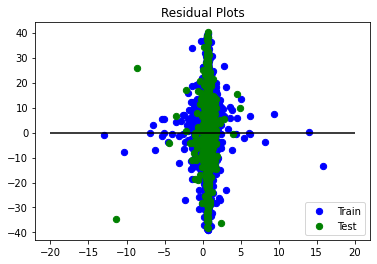

In [260]:
# Plotting Residuals
plt.scatter(lin_reg.predict(x_train), lin_reg.predict(x_train)-y_train, c='b',s=40)
plt.scatter(lin_reg.predict(x_test), lin_reg.predict(x_test)-y_test, c='g',s=40,)
plt.hlines(y=0,xmin=-20,xmax=20)
plt.title("Residual Plots")
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

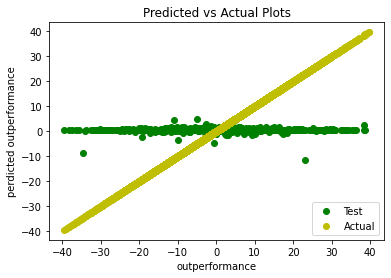

In [262]:
plt.scatter(y_test, y_predict, c= 'g')
plt.scatter(merged_df['outperform_percent'], merged_df['outperform_percent'], c='y')
plt.xlabel('outperformance')
plt.ylabel('perdicted outperformance')
plt.title("Predicted vs Actual Plots")
plt.legend(['Test', 'Actual'], loc='lower right')
plt.show()

PCA with Linear Regression

So, in order to reduce the collinearity and scale the data, I tried to do a PCA transformation. The result is still not predictive. 

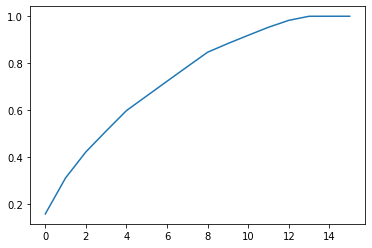

In [263]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x_train_t = StandardScaler().fit_transform(x_train)
x_test_t = StandardScaler().fit_transform(x_test)
pca = PCA(n_components = 16)
pca = pca.fit(x_train_t)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [0]:
pca = PCA(n_components=12)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [265]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [266]:
print(lin_reg.score(x_train, y_train))
print(lin_reg.score(x_test, y_test))

0.0012291080020602196
9.069147568663283e-05


In [267]:
y_predict = lin_reg.predict(x_test)
lin_reg_mse = mean_squared_error(y_predict, y_test)
rmse = math.sqrt(lin_reg_mse)
rmse

10.545489992194815

Lasso 

Similarly, I tried to fit using Lasso, which also gives a bad result.

In [268]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.5)
model_lasso.fit(x_train, y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [269]:
print(lin_reg.score(x_train, y_train))
print(lin_reg.score(x_test, y_test))

pred_train_lasso= model_lasso.predict(x_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))

pred_test_lasso= model_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 

0.0012291080020602196
9.069147568663283e-05
10.5013503074467
10.545654458974143


### Random Forest

The Random Forest model seemed to give a reasonable fit for the training data, but is also very outrageous when used to predict the testing set.

In [270]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=12, n_estimators=20, max_depth = 20)
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=12, verbose=0, warm_start=False)

In [271]:
print(rfr.score(x_train, y_train))
print(rfr.score(x_test, y_test))

0.5874985151702214
-0.0363304981309267


In [272]:
y_predict = rfr.predict(x_test)
rfr_mse = mean_squared_error(y_predict, y_test)
rmse = math.sqrt(rfr_mse)
rmse

10.7358293042994

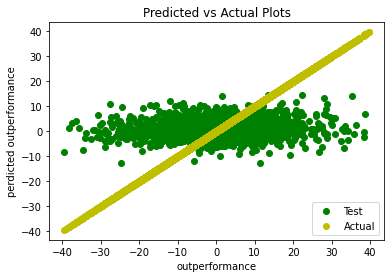

In [274]:
plt.scatter(y_test, y_predict, c= 'g')
plt.scatter(merged_df['outperform_percent'], merged_df['outperform_percent'], c='y')
plt.xlabel('outperformance')
plt.ylabel('perdicted outperformance')
plt.title("Predicted vs Actual Plots")
plt.legend(['Test', 'Actual'], loc='lower right')
plt.show()

## Classification

I still didn't want to give up after all the failed results of the previous regression models. I shifted my assumption to that even though we couldn't predict the actual outperformace of the stocks, we might still be able to tell which stocks will be likely to perform well (above a certain threshold). I picked the threshold as 10% for this analysis. Note that one problem we might encounter is from the imbalance of the data, in which only 16% of the data outperforms the market by 10%.

In [275]:
perfomance_threshold = 10
sum(merged_df['outperform_percent']>perfomance_threshold)

2235

In [276]:
# % of data with values 1
sum(merged_df['outperform_percent']>perfomance_threshold)/len(merged_df['outperform_percent'])

0.16280594405594406

In [0]:
# create a new column called 'significant_perform' which takes the value True or False (1 or 0)
merged_df['significant_perform'] = merged_df['outperform_percent']>perfomance_threshold

In [0]:
from sklearn.model_selection import train_test_split
col_notx = ['date', 'ticker','close','close2','price change','sp500change','outperform_percent','significant_perform']
x_train, x_test, y_train, y_test = train_test_split(merged_df.drop(col_notx, axis=1),
                                                    merged_df['significant_perform'], test_size=0.2, random_state=22)

### Logistic Regression

The score from the simple logistic regression seems like the model is useful for the prediction. However, when plotting the confusion matrix, I could see that even though the accuracy is good, the sensitivity and specificity of the model tells us that there is no true posititive. That is, the model had an overwhelming amount of negative predictions: it predicted that all of the stocks will not outperform the market to the 10% threshold. 

In [279]:
from sklearn.linear_model import LogisticRegression

lin_reg = LogisticRegression(random_state=10)
lin_reg.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [280]:
print(lin_reg.score(x_train, y_train))
print(lin_reg.score(x_test, y_test))

0.8339100346020761
0.8503277494537509


In [281]:
from sklearn.metrics import confusion_matrix

y_predict = lin_reg.predict(x_test)
cma = confusion_matrix(y_test, y_predict)
cma

array([[2335,    0],
       [ 411,    0]])

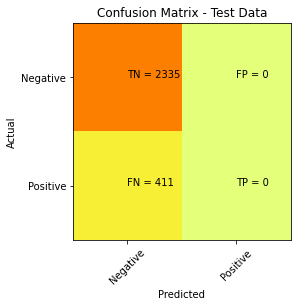

In [282]:
plt.clf()
plt.imshow(cma, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('Actual')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cma[i][j]))
plt.show()

### Random Forest

Similarly, I fitted the random forest model to classify the data. The accuracy scores make a lot of sense. But still, when I plotted the confusion matrix and the ROC curve, I could see that the prediction mostly failed to determine the true positive values. The AUC is only 0.52, and the model cannot be considered useful.

In [283]:
from sklearn.ensemble import RandomForestClassifier
rfr = RandomForestClassifier(random_state=12, n_estimators=20, max_depth = 20)
rfr.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [284]:
print(rfr.score(x_train, y_train))
print(rfr.score(x_test, y_test))

0.9574758696048079
0.8455935906773488


In [285]:
y_predict = rfr.predict(x_test)
cma = confusion_matrix(y_test, y_predict)
cma

array([[2303,   32],
       [ 392,   19]])

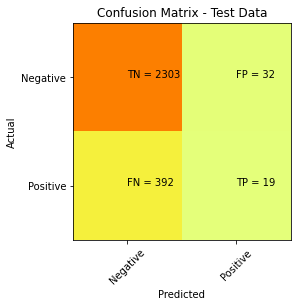

In [286]:
plt.clf()
plt.imshow(cma, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('Actual')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cma[i][j]))
plt.show()

0.5162621068371392


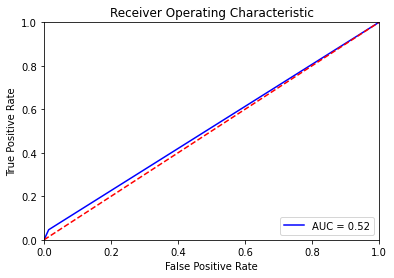

In [287]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predict)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Challenges and Possible Improvement

One main challenge that I might encounter in Part 1 concerns dealing with data outside the training range. This is especially the case with Random Forest prediction. When the model encounters the data it has never seen before, the prediction is far from accurate. One solution is to include more data across time. However, the issue might still be hard to solve, as the market and stock price keeps rising. The performance of the model will be tested on
the data set aside for backtesting, so the result might not be that useful far in the
future when the economic condition changes.

There are also a lot of challenges in Part 2. First of all, it was challenging to find a way to download the fundamental data, and those fundamentals do not get updated every day. Luckily, for public companies, they are required to release quarterly data, and I could find the FundamentalAnalysis Package to extract those data. Still, some of the stock tickers did not work with the package, and I decided to delete those that cause problem while running. A big improvement might be to include more stocks and also analyze the stocks in each industry, which might give more accurate models. 

Another possible improvement is how to deal with correlation inherent in time series data like stock closing price. My time series analysis in Extra: Time Series with Prophet touches on this topic a bit, but is far from ideal. 


# Conclusion

Part 1 gives several good models for the technical analysis of the stock price based on the previous close prices. I hope to make this my starting point/inspiration of creating
profitable trading algorithms.

However, Part 2 fundamental analysis does not give any valuable model. The biggest takeaways can  be that the assumption is not valid. Still, this also agrees with the random walk theory. When switching to do the classification instead, the accuracy is quite good. However, that was mostly the result of saying that most of the stocks will not outperform the market that much. 

Although only Part 1 yields a meaningful result, I chose to include part 2 of the project, as similar analysis to part 1 has been done all over the world. I thought Part 2 would give a different viewpoint on how to approach quantitative finance. Still, there is a lot of room for improvement and stuff for me to learn. And of course, nothing in this market is perfectly explainable. Experts are still having
a hard time predicting the market. The performance of the model will be tested on
the data set aside for backtesting, so the result might not be that useful far in the
future when the economic condition changes. I was not that surprised that my part 2 analysis didn't work, as if such a simple model could work well, then quantitative finance would not be such a complex and intriguing field. 

Therefore, while not all my models might be applicable for now, I chose to this part for the project because I believe this can lead to effective modifications or further research.